# Multi-Class Image Classification for Robust Outdoor Weather Recognition


**Authors**: [Dominic Muli](mailto:dominic.muli@student.moringaschool.com), [Evangeline Ngunjiri](mailto:evangeline.ngunjiri@student.moringaschool.com), and [Ivy Ndunge](mailto:ivy.ndunge@student.moringaschool.com)

## 1.0) Project Overview

## 1.1) Business Problem

## 1.2) Objectives

## 1.3) Metric of Success

## 1.4) Data Relevance and Validation

## 2.0) Understanding the Data

This dataset cons
https://data.mendeley.com/datasets/4drtyfjtfy/1?ref=hackernoon.com

## 2.1) Reading the Data

### 2.1.1) Installations

In [1]:
# installations
# %pip install tensorflow
# %conda install -c conda-forge scikit-image
# %pip install pillow
# %pip install tqdm
# %pip install --upgrade numpy
# %pip install --upgrade scipy


### 2.1.2) Importing Relevant Libraries

In [1]:
# importing necessary libraries
import os, shutil
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib 
from matplotlib import pyplot as plt
import random
from collections import Counter
from tqdm import tqdm
from PIL import Image
from scipy import ndimage
from shutil import copyfile
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
np.random.seed(123)

%matplotlib inline

### 2.1.3) Reading the Data

In [2]:
# reading the data

# path to the dataset
dataset_path = './data/dataset2/'

# List of supported weather classes based on file naming conventions
weather_classes = ['cloudy', 'rain', 'shine', 'sunrise']

# Dictionary to map weather class names to numerical labels
label_map = {weather_class: idx for idx, weather_class in enumerate(weather_classes)}

images_list = []
labels_list = []

filepaths = []
word_labels = []

# Function to extract class label from filename
def extract_label(filename):
    for weather_class in weather_classes:
        if weather_class in filename:
            return label_map[weather_class]
    return None

# Loop through each image file in the dataset directory
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    
    try:
        # Open image using PIL
        img = Image.open(img_path)
        
        # Convert image to numpy array
        img = np.array(img)
        
        # Extract class label from the filename
        label = extract_label(img_file)
        word_label = [key for key, value in label_map.items() if value == label][0]
        if label is not None:
            # Append the image and its label to the lists
            images_list.append(img)
            labels_list.append(label)
            filepaths.append(img_path)
            word_labels.append(word_label)

    except Exception as e:
        print(f"Error processing image '{img_file}': {e}")

# Convert lists to numpy arrays
images = np.array(images_list)
labels = np.array(labels_list)
data = {'filepaths': filepaths, 'word_labels': word_labels}
df = pd.DataFrame(data)

print(f"Total images: {len(images)}")
print(f"Total labels: {len(labels)}")
df

Processing images:   0%|          | 1/1125 [00:00<02:55,  6.40it/s]

Processing images: 100%|██████████| 1125/1125 [00:19<00:00, 56.76it/s]


Total images: 1125
Total labels: 1125


,filepaths,word_labels
0,./data/dataset2/cloudy1.jpg,cloudy
1,./data/dataset2/cloudy10.jpg,cloudy
2,./data/dataset2/cloudy100.jpg,cloudy
3,./data/dataset2/cloudy101.jpg,cloudy
4,./data/dataset2/cloudy102.jpg,cloudy
...,...,...
1120,./data/dataset2/sunrise95.jpg,sunrise
1121,./data/dataset2/sunrise96.jpg,sunrise
1122,./data/dataset2/sunrise97.jpg,sunrise
1123,./data/dataset2/sunrise98.jpg,sunrise


## 2.2) EDA before Preprocessing

### 2.2.1) Image preview

We will inspect 20 random images from the dataset

<ipython-input-3-9e0dc8a099de>:12: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, num_samples/5, i + 1)


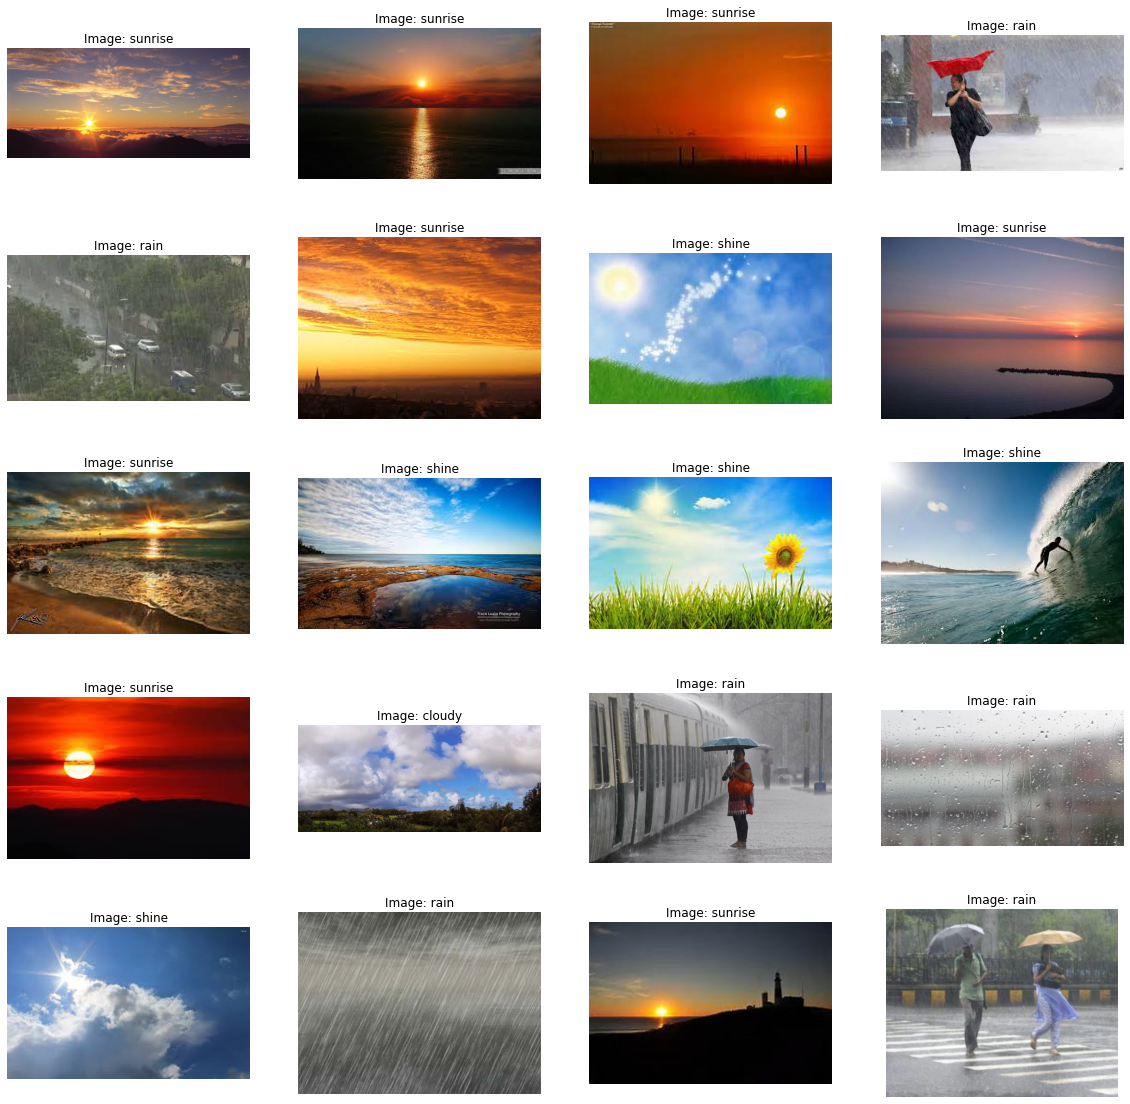

In [3]:
# previewing random images

def visualize_random_images(num_samples=20):
    plt.figure(figsize=(20, 20))
    for i in range(num_samples):
        random_idx = random.randint(0, len(images) - 1) 
        random_image = images[random_idx]
        
        filename = [key for key, value in label_map.items() if value == labels[random_idx]][0]
        
        # Displaying the image
        plt.subplot(5, num_samples/5, i + 1)
        plt.imshow(random_image)
        plt.title(f"Image: {filename}")
        plt.axis("off")
    plt.show()

visualize_random_images()


### 2.2.2) Weather Class Distribution

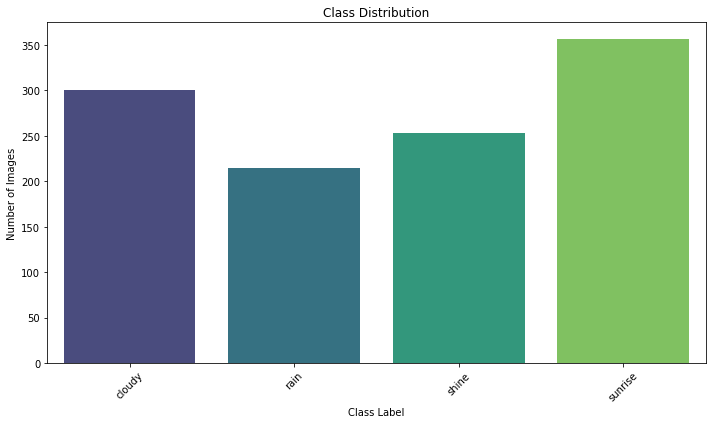

Counter({0: 300, 1: 215, 2: 253, 3: 357})

In [4]:
# class Distribution Visualization

# Get class titles from the label_map
class_titles = [key for key in label_map.keys()]

# Calculate class distribution using Counter
class_distribution = Counter(labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=class_titles, y=list(class_distribution.values()), palette='viridis')
plt.xlabel("Class Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
class_distribution

Observation: The weather classes are relatively evenly distributed. There are 300 images showing cloudy weather, 215 images showing rainy weather, 253 images showing shinny weather, and 357 images showing sunrise.

### 2.2.3) Image Size Distribution

Processing images: 100%|██████████| 1125/1125 [00:00<00:00, 1127.69it/s]


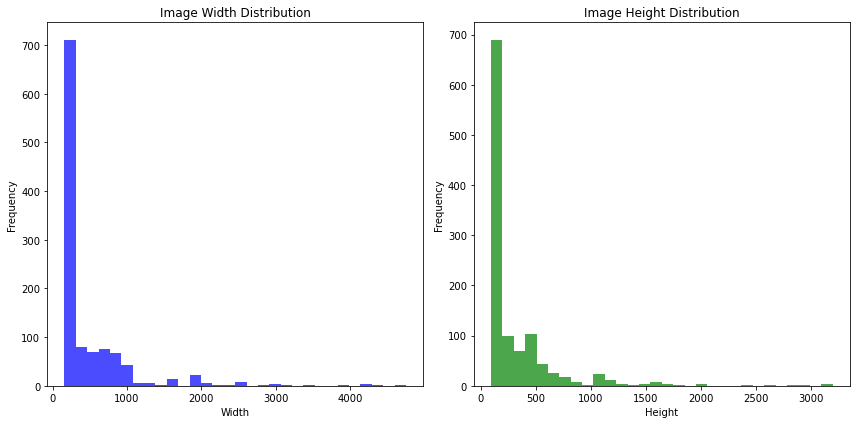

In [5]:
# image size distribution
image_sizes = []
for img_file in tqdm(os.listdir(dataset_path), desc='Processing images'):
    img_path = os.path.join(dataset_path, img_file)
    img = Image.open(img_path)
    width, height = img.size
    image_sizes.append((width, height))

widths, heights = zip(*image_sizes)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='blue', alpha=0.7)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='green', alpha=0.7)
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Observation: The images have varying sizes (height and width).

### 2.2.4) Image Pixel Distribution

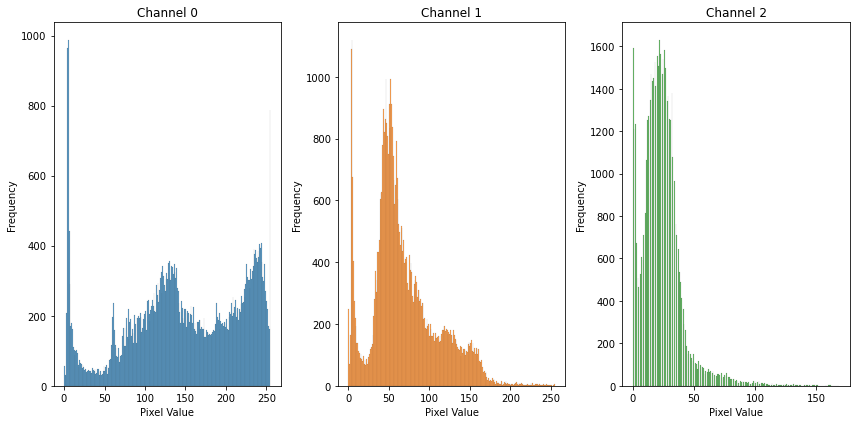

In [6]:
# Convert image to a NumPy array
img_array = np.array(img)

# Display pixel value distributions
plt.figure(figsize=(12, 6))

# Plot histograms for each color channel
for i in range(img_array.shape[2]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(img_array[:, :, i].ravel(), bins=256, color=f'C{i}', alpha=0.7)
    plt.title(f'Channel {i}')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

plt.tight_layout()

Observation: the RGB color distribution 

### 2.2.5) Label Mappings

In [19]:
# viewing label mappings
for key, value in label_map.items():
    print(f"{key} : {value}")

cloudy : 0
rain : 1
shine : 2
sunrise : 3


## 2.3) Data Preprocessing

### 2.3.1) Splitting the Data

In [12]:
# Setting the paths for the train, test, and validation directories
train_imgs = "./data/traindataset/"
test_imgs = "./data/testdataset/"
val_imgs = "./data/valdataset/"

# Defining split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Creating directories
os.makedirs(train_imgs, exist_ok=True)
os.makedirs(test_imgs, exist_ok=True)
os.makedirs(val_imgs, exist_ok=True)

# Splitting the DataFrame into train, validation, and test sets
train_df, df_2 = train_test_split(df, train_size=train_ratio, random_state=42, shuffle=True)
val_df, test_df = train_test_split(df_2, test_size=val_ratio/(test_ratio+val_ratio), random_state=42, shuffle=True)

# Function to copy files to the specified directory
def copy_files(file_list, source_dir, destination_dir):
    for filepath, label in zip(file_list['filepaths'], file_list['word_labels']):
        filename = os.path.basename(filepath)
        destination_path = os.path.join(destination_dir, f"{filename}")
        copyfile(filepath, destination_path)

# Copying original images to train directory
copy_files(train_df, dataset_path, train_imgs)

# Copying original images to validation directory
copy_files(val_df, dataset_path, val_imgs)

# Copying original images to test directory
copy_files(test_df, dataset_path, test_imgs)

def count_images_in_directory(directory_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Initializing a counter for images
    image_count = 0

    # Iterating through all files
    for filename in os.listdir(directory_path):
        # Checking if the file extension is an image extension
        if any(filename.lower().endswith(ext) for ext in image_extensions):
            image_count += 1

    return image_count

# Get the count of images in the specified directory

num_train_images = count_images_in_directory(train_imgs)
num_val_images = count_images_in_directory(val_imgs)
num_tes_images = count_images_in_directory(test_imgs)

# Checking number of images in split data

print(f"There are, {num_train_images}, outdoor weather images in the training set")
print(f"There are, {num_val_images}, outdoor weather images in the validation set")
print(f"There are, {num_tes_images}, outdoor weather images in the test set")

There are, 787, outdoor weather images in the training set
There are, 169, outdoor weather images in the validation set
There are, 169, outdoor weather images in the test set


In [17]:
# Setting the paths for the train, test, and validation directories
train_imgs = "./data/traindataset/"
test_imgs = "./data/testdataset/"
val_imgs = "./data/valdataset/"

# Defining split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


# Creating directories
os.makedirs(train_imgs, exist_ok=True)
os.makedirs(test_imgs, exist_ok=True)
os.makedirs(val_imgs, exist_ok=True)

# Splitting the DataFrame into train, validation, and test sets
train_df, df_2 = train_test_split(df, train_size=train_ratio, random_state=42, shuffle=True)
val_df, test_df = train_test_split(df_2, test_size=val_ratio/(test_ratio+val_ratio), random_state=42, shuffle=True)

# Function to copy/move files to subdirectories based on weather classes
def organize_images_by_weather_classes(file_list, source_dir, destination_dir, classes):
    for weather_class in classes:
        os.makedirs(os.path.join(destination_dir, weather_class), exist_ok=True)

    for filepath, label in zip(file_list['filepaths'], file_list['word_labels']):
        filename = os.path.basename(filepath)
        weather_class = label.lower()
        if weather_class in classes:
            destination_path = os.path.join(destination_dir, weather_class, filename)
            shutil.copy(filepath, destination_path)

# Copying and organizing images to train directory by weather classes
organize_images_by_weather_classes(train_df, dataset_path, train_imgs, weather_classes)

# Copying and organizing images to validation directory by weather classes
organize_images_by_weather_classes(val_df, dataset_path, val_imgs, weather_classes)

# Copying and organizing images to test directory by weather classes
organize_images_by_weather_classes(test_df, dataset_path, test_imgs, weather_classes)

# Function to count number of images in each subdirectory
def count_images_in_subdirectories(parent_directory, classes):
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']

    # Dictionary to store image counts for each class
    image_counts = {cls: 0 for cls in classes}

    # Iterating through each class directory and counting images
    for cls in classes:
        directory_path = os.path.join(parent_directory, cls)
        if os.path.exists(directory_path):
            for filename in os.listdir(directory_path):
                if any(filename.lower().endswith(ext) for ext in image_extensions):
                    image_counts[cls] += 1

    return image_counts

# Getting the count of images in each subdirectory
num_train_images = count_images_in_subdirectories(train_imgs, weather_classes)
num_val_images = count_images_in_subdirectories(val_imgs, weather_classes)
num_test_images = count_images_in_subdirectories(test_imgs, weather_classes)

# Displaying number of images in each class within directories
for cls in weather_classes:
    print(f"There are {num_train_images[cls]} {cls} images in the training set")
    print(f"There are {num_val_images[cls]} {cls} images in the validation set")
    print(f"There are {num_test_images[cls]} {cls} images in the test set")

There are 209 cloudy images in the training set
There are 45 cloudy images in the validation set
There are 46 cloudy images in the test set
There are 143 rain images in the training set
There are 33 rain images in the validation set
There are 39 rain images in the test set
There are 178 shine images in the training set
There are 37 shine images in the validation set
There are 38 shine images in the test set
There are 257 sunrise images in the training set
There are 54 sunrise images in the validation set
There are 46 sunrise images in the test set


### 2.3.1) Image Generation

### 2.3.2) Image Data Augmentation

In [18]:
# data augmentation and flow_from_directory
target_width = int(np.mean(widths))
target_height = int(np.mean(heights))
img_size = (target_width, target_height)
channels = 3

train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_data_gen = ImageDataGenerator(rescale=1./255)

batch_size = 16

# Flowing data from directories
train_gen = train_data_gen.flow_from_directory(train_imgs, target_size=img_size, class_mode='categorical',
                                               color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = val_data_gen.flow_from_directory(val_imgs, target_size=img_size, class_mode='categorical',
                                             color_mode='rgb', shuffle=True, batch_size=batch_size)

Found 787 images belonging to 4 classes.
Found 169 images belonging to 4 classes.


## 2.4) Building Model

In [ ]:
# Creating a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


## 2.5) Conclusion

## 2.6) Recommendation